<a href="https://colab.research.google.com/github/mmarin11/Colabfiles/blob/main/Practica2/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Extracción de Información con Expresiones Regulares**

El objetivo del código es extraer información del archivo informe_acciones.txt usando re, obtener el valor de la acción por empresa y calcular los valores máximo, mínimo, promedio, varianza poblacional y desviación estandar.

Cargar el archvo al directorio de Google drive en la siguiente ruta /content/drive/MyDrive/ClassFiles/informe_acciones.txt. Es importante el archivo se cargue a la ruta específica para que el script pueda correr de manera exitosa.



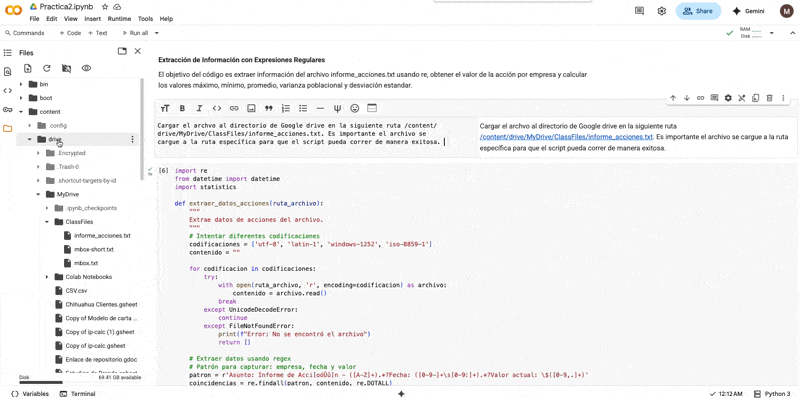

In [8]:
import re
from datetime import datetime
import statistics

def extraer_datos_acciones(ruta_archivo):
    """
    Extrae datos de acciones del archivo.
    """
    # Intentar diferentes codificaciones
    codificaciones = ['utf-8', 'latin-1']
    contenido = ""

    for codificacion in codificaciones:
        try:
            with open(ruta_archivo, 'r', encoding=codificacion) as archivo:
                contenido = archivo.read()
            break
        except UnicodeDecodeError:
            continue
        except FileNotFoundError:
            print(f"Error: No se encontró el archivo")
            return []

    # Extraer datos usando regex
    # Patrón para capturar: empresa, fecha y valor
    patron = r'Asunto: Informe de Acci[oóÛû]n - ([A-Z]+).*?Fecha: ([0-9-]+\s[0-9:]+).*?Valor actual: \$([0-9,.]+)'
    coincidencias = re.findall(patron, contenido, re.DOTALL)

    datos = []
    for empresa, fecha_str, valor_str in coincidencias:
        try:
            fecha = datetime.strptime(fecha_str, '%Y-%m-%d %H:%M:%S')
            valor = float(valor_str.replace(',', ''))
            datos.append({
                'empresa': empresa,
                'fecha': fecha,
                'valor': valor
            })
        except ValueError:
            continue

    return datos

def calcular_estadisticas_por_empresa(datos):
    """
    Calcula estadísticas por empresa.
    """
    empresas = {}

    # Agrupar datos por empresa
    for dato in datos:
        empresa = dato['empresa']
        if empresa not in empresas:
            empresas[empresa] = {
                'valores': [],
                'fechas': []
            }
        empresas[empresa]['valores'].append(dato['valor'])
        empresas[empresa]['fechas'].append(dato['fecha'])

    # Calcular estadísticas
    resultados = []
    for empresa, info in empresas.items():
        valores = info['valores']
        fechas = info['fechas']

        fecha_reciente = max(fechas)
        valor_max = max(valores)
        valor_min = min(valores)
        promedio = statistics.mean(valores)
        varianza = statistics.variance(valores) if len(valores) > 1 else 0
        desviacion = statistics.stdev(valores) if len(valores) > 1 else 0

        resultados.append({
            'empresa': empresa,
            'fecha_reciente': fecha_reciente.strftime('%Y-%m-%d'),
            'valor_max': valor_max,
            'valor_min': valor_min,
            'promedio': promedio,
            'varianza': varianza,
            'desviacion': desviacion
        })

    return resultados

def mostrar_tabla_resultados(resultados):
    """
    Muestra los resultados en formato tabla.
    """
    print("=" * 100)
    print("                           ANÁLISIS DE ACCIONES")
    print("=" * 100)

    # Encabezados de la tabla
    encabezados = ["Empresa", "Fecha más reciente", "Valor Máx ($)", "Valor Mín ($)",
                   "Promedio ($)", "Varianza ($^2)", "Std. Dev ($)"]

    # Imprimir encabezados
    print(f"{'Empresa':<12} | {'Fecha más reciente':<18} | {'Valor Máx ($)':<13} | {'Valor Mín ($)':<13} | {'Promedio ($)':<12} | {'Varianza ($^2)':<14} | {'Std. Dev ($)':<12}")
    print("-" * 100)

    # Imprimir datos
    for resultado in resultados:
        print(f"{resultado['empresa']:<12} | {resultado['fecha_reciente']:<18} | "
              f"{resultado['valor_max']:>11.2f} | {resultado['valor_min']:>11.2f} | "
              f"{resultado['promedio']:>10.2f} | {resultado['varianza']:>12.2f} | "
              f"{resultado['desviacion']:>10.2f}")

def main():
    """
    Función principal.
    """
    ruta_archivo = '/content/drive/MyDrive/ClassFiles/informe_acciones.txt'

    # Extraer datos
    datos = extraer_datos_acciones(ruta_archivo)

    if not datos:
        print("No se pudieron extraer datos del archivo.")
        return

    # Calcular estadísticas
    resultados = calcular_estadisticas_por_empresa(datos)

    # Mostrar tabla
    mostrar_tabla_resultados(resultados)

if __name__ == "__main__":
    main()

                           ANÁLISIS DE ACCIONES
Empresa      | Fecha más reciente | Valor Máx ($) | Valor Mín ($) | Promedio ($) | Varianza ($^2) | Std. Dev ($)
----------------------------------------------------------------------------------------------------
CSCO         | 2024-09-02         |     1499.73 |      104.72 |     794.88 |    168905.13 |     410.98
AMZN         | 2024-09-02         |     1498.27 |      103.83 |     762.75 |    162759.93 |     403.44
NVDA         | 2024-09-02         |     1496.06 |      103.26 |     806.61 |    155798.31 |     394.71
MRK          | 2024-09-02         |     1495.62 |      102.43 |     804.27 |    168507.55 |     410.50
MSFT         | 2024-09-02         |     1494.97 |      104.05 |     819.01 |    156980.25 |     396.21
HD           | 2024-09-02         |     1490.53 |      101.10 |     798.42 |    161055.21 |     401.32
CRM          | 2024-09-02         |     1497.80 |      106.33 |     816.63 |    158406.92 |     398.00
XOM          | 20